In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/watai-open-project-f23-beginner-classical-ml/beginner_data_cml.npz


In [2]:
# IMPORT STATEMENTS...
import numpy as np
import xgboost as xgb

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV



#LOADING DATA...
with np.load("/kaggle/input/watai-open-project-f23-beginner-classical-ml/beginner_data_cml.npz") as data:
    X_train = data['train_images']  # Shape (8981, 64, 64, 3)
    y_train = data['train_labels']  # Shape (8981,)
    X_test = data['test_images']  # Shape (1800, 64, 64, 3)
    # we don't have y_test because the labels for the test is the basis of the scoring in the competition...
    
#creating target vectors for the classification task...
y_train_1 = (y_train == 1)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
#doing the training set alterations...
print("flattening training set...")
# Reshape the image data to 2D
X_train_flattened = X_train.reshape(X_train.shape[0], -1)  # Flatten each image
# Make sure to apply the same reshaping procedure to the test data when you want to make predictions on it.

print("creating classifier...")
# Reducing complexity
#clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

clf = XGBClassifier(n_estimators=500, max_depth=16, n_jobs=-1)


flattening training set...
creating classifier...


In [4]:
n_splits = 5 # number of cross-validation splits

#parameters for hyperparameter tuning...
param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(5, 20),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    # Add other XGBoost hyperparameters as needed
}

kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

In [5]:
print("performing random search with {}-fold cross_validation...".format(n_splits))
random_search= RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=1, cv=kf, scoring='accuracy', n_jobs=-1, random_state=42)

performing random search with 5-fold cross_validation...


In [6]:
print("fitting random search to our data...")
# Fit the random search to your data
random_search.fit(X_train_flattened, y_train_1)

cv_results = random_search.cv_results_
for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
    print(mean_score, params)

print("getting the best hyperparameters and model...")
# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("training the best model on our data...")
# Train the best model on the training data
best_model.fit(X_train_flattened, y_train_1)

print("getting the y predictions...")
#dosen't have decision_function() method, so we need its predict_proba() method that returns class probabilties for each instance
y_pred = best_model.predict(X_train_flattened)
y_pred[:2]

fitting random search to our data...


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


0.8944439073784196 {'learning_rate': 0.2, 'max_depth': 17, 'n_estimators': 370}
getting the best hyperparameters and model...
training the best model on our data...
getting the y predictions...


array([0, 0])

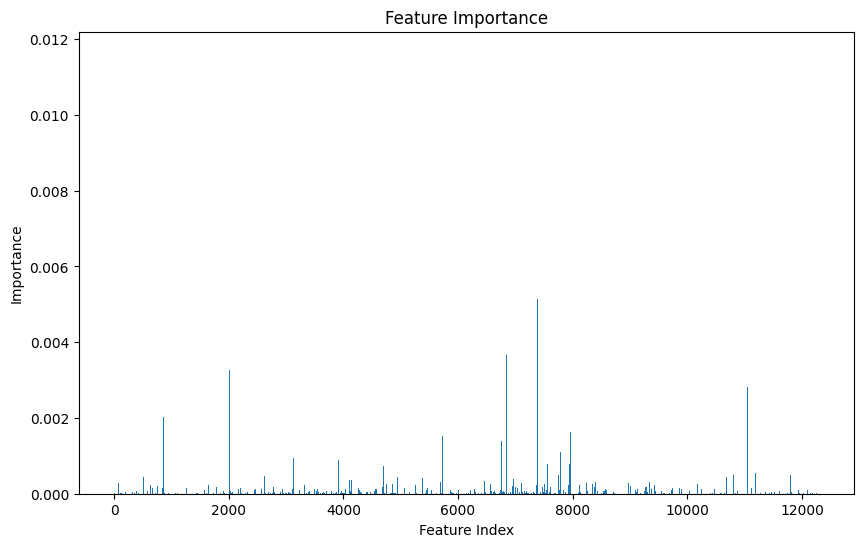

In [7]:
#plotting important features
feature_importance = best_model.feature_importances_
n_features = X_train_flattened.shape[1]

plt.figure(figsize=(10, 6))
plt.bar(range(n_features), feature_importance, align="center")
plt.title("Feature Importance")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

In [8]:
# Calculate precision and recall at different probability thresholds
y_scores = best_model.predict_proba(X_train_flattened)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train_1, y_scores)

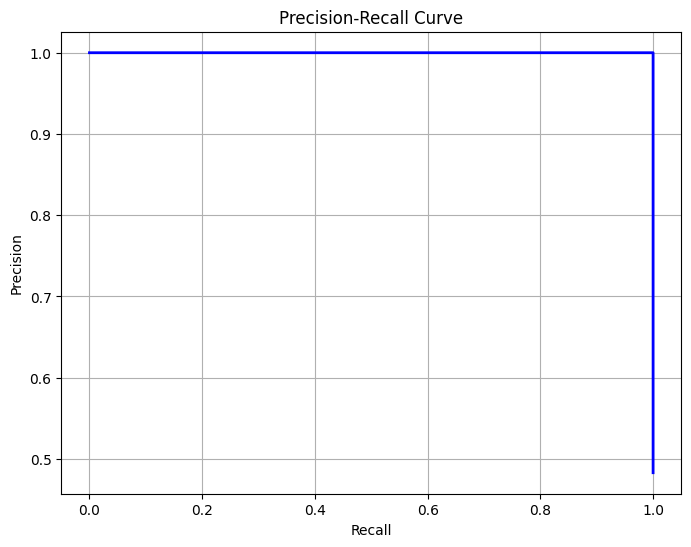

In [9]:
# Plot the precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, 'b-', linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

In [10]:
f1_score(y_train_1, y_pred)

1.0

In [11]:
roc_auc_score(y_train_1, y_pred)

1.0

In [12]:
precision_score(y_train_1, y_pred)

1.0

In [13]:
recall_score(y_train_1, y_pred)

1.0

In [14]:
# Reshape the image data to a 2D array (flattening)
X_test_flattened = X_test.reshape(X_test.shape[0], -1)

# Now you can make predictions
predictions = best_model.predict(X_test_flattened)

N_test = X_test.shape[0]
df = pd.DataFrame({
    "Index": np.arange(N_test),
    "Label": predictions
})
df.to_csv("submission.csv", index=False)